<a href="https://colab.research.google.com/github/subhobrata/Pytorch_examples/blob/master/WHAT_IS_TORCH_NN_REALLY.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from pathlib import Path
import requests

DATA_PATH = Path("data")
PATH = DATA_PATH / "mnist"

PATH.mkdir(parents=True, exist_ok=True)

URL = "http://deeplearning.net/data/mnist/"
FILENAME = "mnist.pkl.gz"

if not (PATH / FILENAME).exists():
        content = requests.get(URL + FILENAME).content
        (PATH / FILENAME).open("wb").write(content)

In [0]:
import pickle
import gzip

with gzip.open((PATH / FILENAME).as_posix(), "rb") as f:
        ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding="latin-1")

(50000, 784)


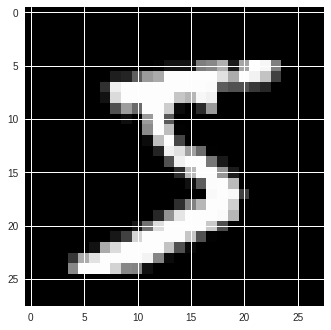

In [0]:
from matplotlib import pyplot
import numpy as np

pyplot.imshow(x_train[0].reshape((28, 28)), cmap="gray")
print(x_train.shape)

In [0]:
import torch

x_train, y_train, x_valid, y_valid = map(
    torch.tensor, (x_train, y_train, x_valid, y_valid)
)
n, c = x_train.shape
x_train, x_train.shape, y_train.min(), y_train.max()
print(x_train, y_train)
print(x_train.shape)
print(y_train.min(), y_train.max())

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]]) tensor([5, 0, 4,  ..., 8, 4, 8])
torch.Size([50000, 784])
tensor(0) tensor(9)


with torch.no_grad() is a context manager and is used to prevent calculating gradients in the following code block.
Usually it is used when you evaluate your model and don’t need to call backward() to calculate the gradients and update the corresponding parameters.
Also, you can use it to initialize the weights with torch.nn.init functions, since you don’t need the gradients there either.

requires_grad on the other hand is used when creating a tensor, which should require gradients. Usually you don’t need this in the beginning, as all parameters which require gradients are already wrapped in nn.Modules in the nn package.
You could set this property e.g. on your input tensor, if you need to update your input for example in an adversarial training setup.

In [0]:
import math

weights = torch.randn(784, 10) / math.sqrt(784)
weights.requires_grad_()
bias = torch.zeros(10, requires_grad=True)

In [0]:
def log_softmax(x):
  return x - x.exp().sum(-1).log().unsqueeze(-1)

def model(xb):
  return log_softmax(xb@weights+bias)


In [0]:
bs=64 #batch_size

xb = x_train[0:bs] # a mini batch size from x
preds = model(xb) #prediction
preds[0], preds.shape
print(preds[0],preds.shape)

tensor([-2.1557, -2.7084, -1.8120, -2.3411, -2.5744, -2.2799, -2.2937, -2.4389,
        -2.0959, -2.6828], grad_fn=<SelectBackward>) torch.Size([64, 10])


In [0]:
def nll(input,target):
  return -input[range(target.shape[0]),target].mean()

loss_func = nll
type(nll)
type(loss_func)

function

In [0]:
yb = y_train[0:bs]
print(loss_func(preds,yb))

tensor(2.3222, grad_fn=<NegBackward>)


In [0]:
def accuracy(out,yb):
  preds = torch.argmax(out,dim=1)
  return (preds == yb).float().mean()

In [0]:
print(accuracy(preds,yb))

tensor(0.1406)


In [0]:
from IPython.core.debugger import set_trace

lr = 0.5  # learning rate
epochs = 2  # how many epochs to train for

for epoch in range(epochs):
    for i in range((n - 1) // bs + 1):
        #         set_trace()
        start_i = i * bs
        end_i = start_i + bs
        xb = x_train[start_i:end_i]
        yb = y_train[start_i:end_i]
        pred = model(xb)
        loss = loss_func(pred, yb)

        loss.backward()
        with torch.no_grad():
            weights -= weights.grad * lr
            bias -= bias.grad * lr
            weights.grad.zero_()
            bias.grad.zero_()

In [0]:
print(loss_func(model(xb), yb), accuracy(model(xb), yb))

tensor(0.0825, grad_fn=<NegBackward>) tensor(1.)


In [0]:
import torch.nn.functional as F

loss_func = F.cross_entropy

def model(xb):
  return xb@weights + bias


In [0]:
print(loss_func(model(xb), yb), accuracy(model(xb), yb))

tensor(0.0825, grad_fn=<NllLossBackward>) tensor(1.)


In [0]:
from torch import nn

class Mnist_Logistic(nn.Module):
  def __init__(self):
    super().__init__()
    self.weights = nn.Parameter(torch.randn(784,10)/math.sqrt(784))
    self.bias = nn.Parameter(torch.zeros(10))
    
  def forward(self,xb):
    return xb@self.weights+self.bias

In [0]:
model = Mnist_Logistic()

In [0]:
print(loss_func(model(xb), yb))

tensor(2.3344, grad_fn=<NllLossBackward>)


In [0]:
with torch.no_grad():
    weights -= weights.grad * lr
    bias -= bias.grad * lr
    weights.grad.zero_()
    bias.grad.zero_()

In [0]:
with torch.no_grad():
    for p in model.parameters(): p -= p.grad * lr
    model.zero_grad()

TypeError: ignored

In [33]:
with torch.no_grad():
    for p in model.parameters(): p -= p.grad * lr
    model.zero_grad()

TypeError: ignored

In [0]:
from torch import optim

In [36]:
def get_model():
    model = Mnist_Logistic()
    return model, optim.SGD(model.parameters(), lr=lr)

model, opt = get_model()
print(loss_func(model(xb), yb))

for epoch in range(epochs):
    for i in range((n - 1) // bs + 1):
        start_i = i * bs
        end_i = start_i + bs
        xb = x_train[start_i:end_i]
        yb = y_train[start_i:end_i]
        pred = model(xb)
        loss = loss_func(pred, yb)

        loss.backward()
        opt.step()
        opt.zero_grad()

print(loss_func(model(xb), yb))

tensor(2.3835, grad_fn=<NllLossBackward>)
tensor(0.0816, grad_fn=<NllLossBackward>)


In [0]:
opt.step()
opt.zero_grad()

In [0]:
from torch.utils.data import TensorDataset

In [0]:
train_ds = TensorDataset(x_train,y_train)

In [0]:
xb = x_train[start_i:end_i]
yb = y_train[start_i:end_i]

In [0]:
xb,yb = train_ds[i*bs:i*bs+bs]

In [42]:
model, opt = get_model()

for epoch in range(epochs):
    for i in range((n - 1) // bs + 1):
        xb, yb = train_ds[i * bs: i * bs + bs]
        pred = model(xb)
        loss = loss_func(pred, yb)

        loss.backward()
        opt.step()
        opt.zero_grad()

print(loss_func(model(xb), yb))

tensor(0.0842, grad_fn=<NllLossBackward>)


In [0]:
from torch.utils.data import DataLoader

In [0]:
train_ds = TensorDataset(x_train, y_train)
train_dl = DataLoader(train_ds, batch_size=bs)

In [0]:
for i in range((n-1)//bs + 1):
    xb,yb = train_ds[i*bs : i*bs+bs]
    pred = model(xb)

In [0]:
for xb,yb in train_dl:
    pred = model(xb)

In [48]:
model, opt = get_model()

for epoch in range(epochs):
    for xb, yb in train_dl:
        pred = model(xb)
        loss = loss_func(pred, yb)

        loss.backward()
        opt.step()
        opt.zero_grad()

print(loss_func(model(xb), yb))

tensor(0.0813, grad_fn=<NllLossBackward>)


In [0]:
train_ds = TensorDataset(x_train, y_train)
train_dl = DataLoader(train_ds, batch_size=bs, shuffle=True)

In [0]:
valid_ds = TensorDataset(x_valid, y_valid)
valid_dl = DataLoader(valid_ds, batch_size=bs * 2)

In [51]:
model, opt = get_model()

for epoch in range(epochs):
    model.train()
    for xb, yb in train_dl:
        pred = model(xb)
        loss = loss_func(pred, yb)

        loss.backward()
        opt.step()
        opt.zero_grad()

    model.eval()
    with torch.no_grad():
        valid_loss = sum(loss_func(model(xb), yb) for xb, yb in valid_dl)

    print(epoch, valid_loss / len(valid_dl))

0 tensor(0.3183)
1 tensor(0.3197)


In [0]:
def loss_batch(model, loss_func, xb, yb, opt=None):
    loss = loss_func(model(xb), yb)

    if opt is not None:
        loss.backward()
        opt.step()
        opt.zero_grad()

    return loss.item(), len(xb)

In [0]:
import numpy as np

def fit(epochs, model, loss_func, opt, train_dl, valid_dl):
    for epoch in range(epochs):
        model.train()
        for xb, yb in train_dl:
            loss_batch(model, loss_func, xb, yb, opt)

        model.eval()
        with torch.no_grad():
            losses, nums = zip(
                *[loss_batch(model, loss_func, xb, yb) for xb, yb in valid_dl]
            )
        val_loss = np.sum(np.multiply(losses, nums)) / np.sum(nums)

        print(epoch, val_loss)

In [0]:
def get_data(train_ds, valid_ds, bs):
    return (
        DataLoader(train_ds, batch_size=bs, shuffle=True),
        DataLoader(valid_ds, batch_size=bs * 2),
    )


In [55]:
train_dl, valid_dl = get_data(train_ds, valid_ds, bs)
model, opt = get_model()
fit(epochs, model, loss_func, opt, train_dl, valid_dl)

0 0.3032454061985016
1 0.3027892698764801


In [0]:
class Mnist_CNN(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(1,16,kernal_size=3,stride=2,padding=1)
    self.conv2 = nn.Conv2d(16,16,kernal_size=3,stride=2,padding=1)
    self.conv3 = nn.Conv2d(16,10,kernal_size=3,stride=2,padding=1)
    
  def forward(self,xb):
    xb = xb.view(-1,1,28,28)
    xb = F.relu(self.conv1(xb))
    xb = F.relu(self.conv2(xb))
    xb = F.relu(self.conv2(xb))
    xb = F.avg_pool2d(xb,4)
    return xb.view(-1,xb.size(1))
  
lr = 0.1

In [58]:
model = Mnist_CNN()
opt = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

fit(epochs, model, loss_func, opt, train_dl, valid_dl)

TypeError: ignored

In [0]:
class Lambda(nn.Module):
    def __init__(self, func):
        super().__init__()
        self.func = func

    def forward(self, x):
        return self.func(x)


def preprocess(x):
    return x.view(-1, 1, 28, 28)

In [60]:
model = nn.Sequential(
    Lambda(preprocess),
    nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.Conv2d(16, 16, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.Conv2d(16, 10, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.AvgPool2d(4),
    Lambda(lambda x: x.view(x.size(0), -1)),
)

opt = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

fit(epochs, model, loss_func, opt, train_dl, valid_dl)

0 0.43244185638427735
1 0.23764800176620485
